In [16]:
import sys
sys.path.append('../src')

import torch
import numpy as np

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from modules import IDC
from utils import get_synthetic_dataset, plot_synthetic_dataset, clustering_accuracy, uniqueness, diversity, feature_importance_accuracy_drop
from trainer import idc_trainer, device
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari

from sklearn.cluster import KMeans

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Synthetic Data

In [4]:
synthetic_X, synthetic_y = get_synthetic_dataset()
synthetic_X = (synthetic_X - synthetic_X.min()) / (synthetic_X.max() - synthetic_X.min())

In [5]:
idc_synthetic_75 = torch.load("../models/synthetic_model_75.pth")

### IDC With local gates

In [6]:
with torch.no_grad():
    X = synthetic_X.to(device)
    X_Z ,z , _ = idc_synthetic_75.gnn(X)
    H = idc_synthetic_75.ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = idc_synthetic_75.clusterNN(X_Z, H)
    clust_yhat = clust_logits.argmax(dim=1).cpu()
    
    synthetic_nmi = nmi(clust_yhat, synthetic_y)
    print(f"NMI = {synthetic_nmi:.4f}")
    
    synthetic_ari = ari(clust_yhat, synthetic_y)
    print(f"ARI = {synthetic_ari:.4f}")
    
    synthetic_acc = clustering_accuracy(clust_yhat, synthetic_y)
    print(f"ACC = {synthetic_acc:.4f}")
    
    synthetic_S = (z != 0).sum() / z.size(0)
    print(f"S = {synthetic_S:.4f}")

NMI = 0.8497
ARI = 0.7115
ACC = 0.7491
S = 3.2606


### IDC Without local gates

In [7]:
with torch.no_grad():
    X = synthetic_X.to(device)
    H = idc_synthetic_75.ae.encoder(X)

    clust_logits, aux_logits, u_zg = idc_synthetic_75.clusterNN(X, H)
    clust_yhat = clust_logits.argmax(dim=1).cpu()
    
    synthetic_nmi = nmi(clust_yhat, synthetic_y)
    print(f"NMI = {synthetic_nmi:.4f}")
    
    synthetic_ari = ari(clust_yhat, synthetic_y)
    print(f"ARI = {synthetic_ari:.4f}")
    
    synthetic_acc = clustering_accuracy(clust_yhat, synthetic_y)
    print(f"ACC = {synthetic_acc:.4f}")

NMI = 0.8372
ARI = 0.7052
ACC = 0.7462


### KMEANS

In [8]:
km = KMeans(4)

km.fit(synthetic_X)
km_yhat = km.predict(synthetic_X)

synthetic_nmi = nmi(km_yhat, synthetic_y)
print(f"NMI = {synthetic_nmi:.4f}")

synthetic_ari = ari(km_yhat, synthetic_y)
print(f"ARI = {synthetic_ari:.4f}")

synthetic_acc = clustering_accuracy(km_yhat, synthetic_y)
print(f"ACC = {synthetic_acc:.4f}")

NMI = 1.0000
ARI = 1.0000
ACC = 1.0000


# MNIST Data 

In [9]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_X = mnist_trainset.data.reshape(-1, 784) / 255.
mnist_y = mnist_trainset.targets

subset_size_per_class = 1000
classes = torch.unique(mnist_y)
subset_indices = []
for class_label in classes:
    indices = (mnist_y == class_label).nonzero().squeeze()
    subset_indices.extend(indices[:subset_size_per_class])

import random
random.seed(SEED)
random.shuffle(subset_indices)

mnist_X_subset = mnist_X[subset_indices]
mnist_y_subset = mnist_y[subset_indices]

subset_size_per_class = 100
classes = torch.unique(mnist_y)
subset_indices = []

for class_label in classes:
    indices = (mnist_y == class_label).nonzero().squeeze()
    subset_indices.extend(indices[:subset_size_per_class])
    
mnist_X_subset_XAI = mnist_X[subset_indices]
mnist_y_subset_XAI = mnist_y[subset_indices]

In [10]:
idc_mnist = torch.load("../models/mnist_model_100BS_LARGE_de_OUF.pth")

### IDC With local gates

In [11]:
with torch.no_grad():
    X = mnist_X_subset.to(device)
    X_Z ,z , _ = idc_mnist.gnn(X)
    H = idc_mnist.ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = idc_mnist.clusterNN(X_Z, H)
    clust_yhat = clust_logits.argmax(dim=1).cpu()
    
    mnist_nmi = nmi(clust_yhat, mnist_y_subset)
    print(f"NMI = {mnist_nmi:.4f}")
    
    mnist_ari = ari(clust_yhat, mnist_y_subset)
    print(f"ARI = {mnist_ari:.4f}")
    
    mnist_acc = clustering_accuracy(clust_yhat, mnist_y_subset)
    print(f"ACC = {mnist_acc:.4f}")
    
    mnist_S = (z != 0).sum() / z.size(0)
    print(f"S = {mnist_S:.4f}")
    
    # XAI metrics
    X = mnist_X_subset_XAI.to(device)
    X_Z, z , _ = idc_mnist.gnn(X)

    mnist_uniq = uniqueness(X.cpu().detach(), z.cpu().detach())
    print(f"Uniqueness = {mnist_uniq:.4f}")

    u_zg = idc_mnist.clusterNN.global_gates(torch.arange(10).to(device))
    zg = idc_mnist.clusterNN.hard_thresholding(u_zg)

    mnist_divers = diversity(zg)
    print(f"Diversity = {mnist_divers:.4f}")

NMI = 0.7048
ARI = 0.6513
ACC = 0.7883
S = 31.2232
Uniqueness = 0.5489
Diversity = 0.9516


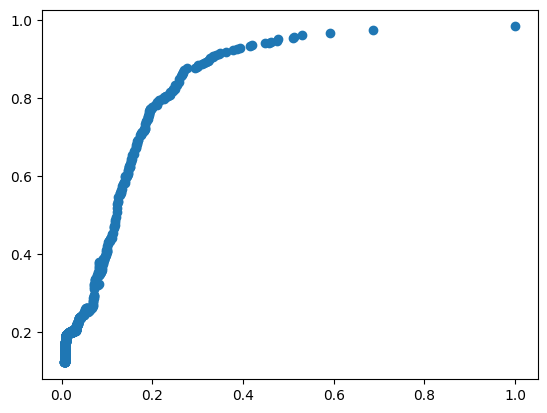

In [14]:
X = mnist_X_subset.to(device)
_, z , _ = idc_mnist.gnn(X)
feature_importances = z.sum(dim=0)
perfs = feature_importance_accuracy_drop(idc_mnist, X, z, feature_importances)
plt.scatter(perfs[:, 0], perfs[:, 1])

### IDC Without local gates

In [12]:
with torch.no_grad():
    X = mnist_X_subset.to(device)
    H = idc_mnist.ae.encoder(X)

    clust_logits, aux_logits, u_zg = idc_mnist.clusterNN(X, H)
    clust_yhat = clust_logits.argmax(dim=1).cpu()
    
    mnist_nmi = nmi(clust_yhat, mnist_y_subset)
    print(f"NMI = {mnist_nmi:.4f}")
    
    mnist_ari = ari(clust_yhat, mnist_y_subset)
    print(f"ARI = {mnist_ari:.4f}")
    
    mnist_acc = clustering_accuracy(clust_yhat, mnist_y_subset)
    print(f"ACC = {mnist_acc:.4f}")

NMI = 0.7368
ARI = 0.6873
ACC = 0.8047


### KMeans + Shap

In [20]:
from sklearn.cluster import KMeans

km = KMeans(10)
km.fit(mnist_X_subset)
yhat = km.predict(mnist_X_subset)

mnist_nmi = nmi(yhat, mnist_y_subset)
print(f"NMI = {mnist_nmi:.4f}")

mnist_ari = ari(yhat, mnist_y_subset)
print(f"ARI = {mnist_ari:.4f}")

mnist_acc = clustering_accuracy(yhat, mnist_y_subset)
print(f"ACC = {mnist_acc:.4f}")

NMI = 0.4698
ARI = 0.3261
ACC = 0.5259


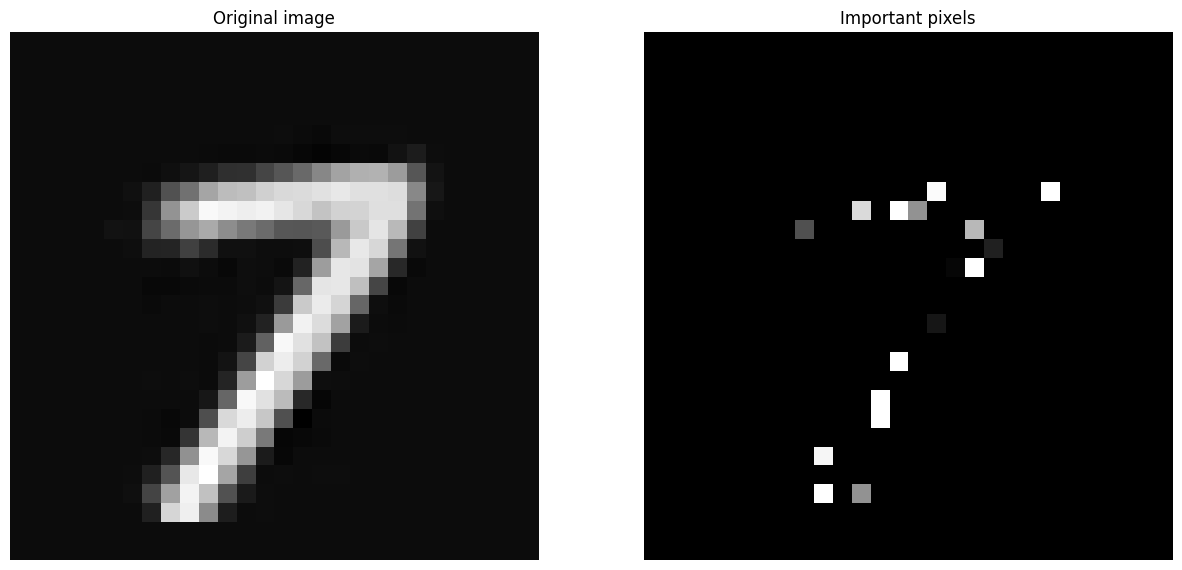

In [21]:
idx = 27

plt.figure(figsize=(15,10))

with torch.no_grad():
    X = mnist_X_subset.to(device)
    X_Z ,z , _ = idc_mnist.gnn(X)
    X_z_hat = idc_mnist.ae(X_Z)
    X_hat = idc_mnist.ae(X)

    plt.subplot(121)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(X_hat[idx].cpu().view(28, 28), cmap='gray')

    plt.subplot(122)
    plt.title("Important pixels")
    plt.axis('off')
    
    plt.imshow(X_Z[idx].cpu().view(28, 28), cmap='gray')

plt.show()